unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

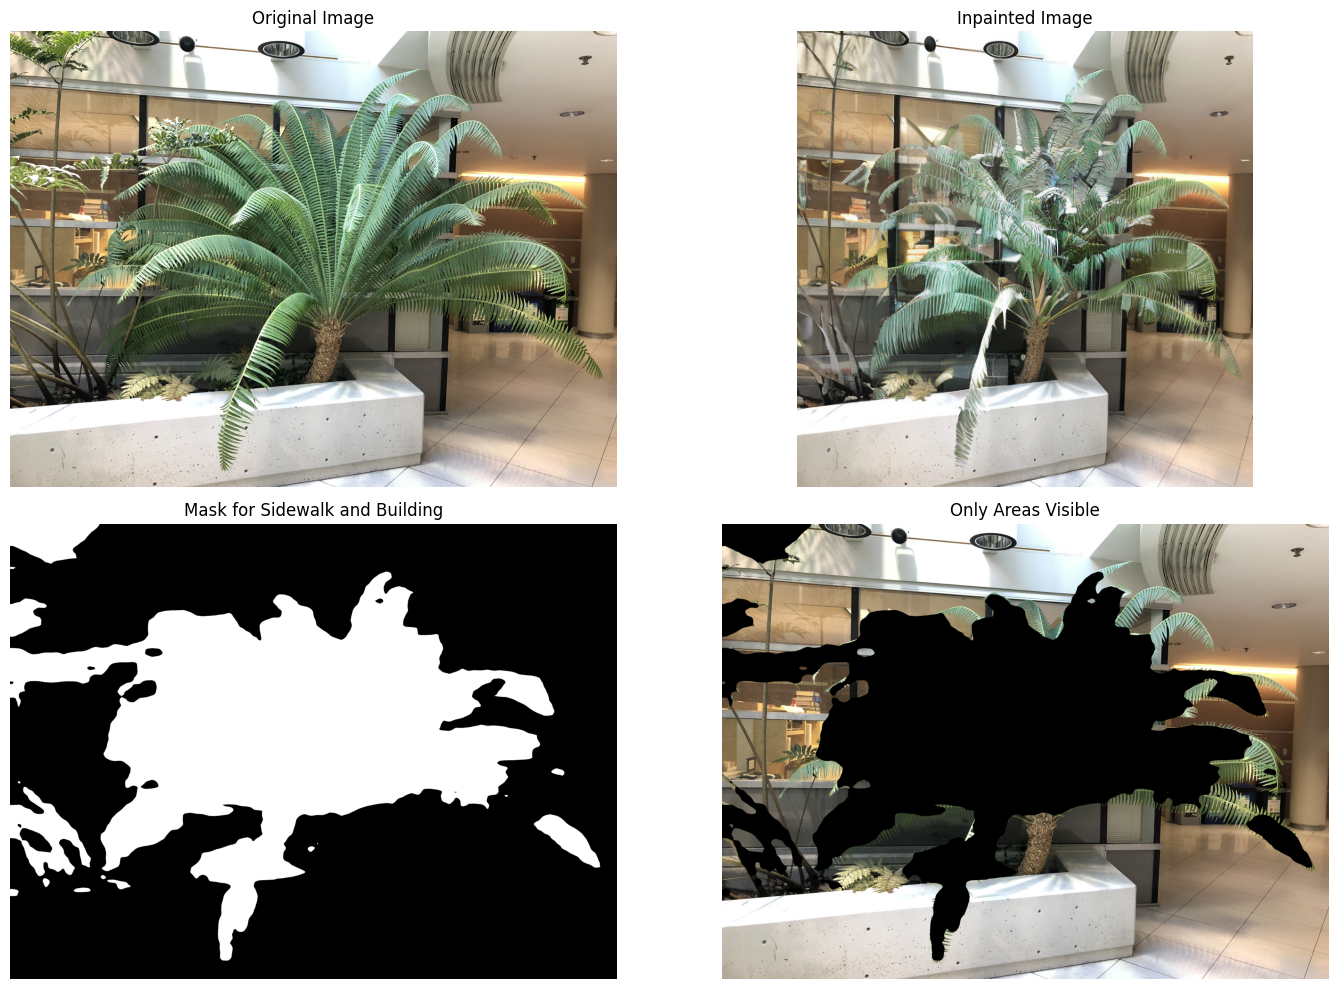

In [5]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cityscapes 类别标签
CITYSCAPES_CLASS_NAMES = [
    "unlabeled", "ego vehicle", "rectification border", "out of roi", "static", "dynamic", "ground", "road",
    "sidewalk", "parking", "rail track", "building", "wall", "fence", "guard rail", "bridge", "tunnel", 
    "pole", "polegroup", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", 
    "rider", "car", "truck", "bus", "caravan", "trailer", "train", "motorcycle", "bicycle", "license plate"
]

# 加载 Mask2Former 模型
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic").to(device)

# 加载本地图像
image_path = "E:/CS5330/Nerf/nerf/data/nerf_llff_data/fern/images/IMG_4026.JPG"
image = Image.open(image_path)
image_np = np.array(image)

# 图像预处理
inputs = image_processor(images=image, return_tensors="pt").to(device)

# 执行分割预测
with torch.no_grad():
    outputs = model(**inputs)

# 生成语义分割图
pred_instance_map = image_processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

# 转换为 numpy 数组（需要先将张量从 GPU 移动到 CPU）
segmentation_map = pred_instance_map.cpu().numpy()

# 获取 "sidewalk" 和 "building" 类别的索引
sidewalk_class = CITYSCAPES_CLASS_NAMES.index("sidewalk")
building_class = CITYSCAPES_CLASS_NAMES.index("building")

# 创建联合掩码
combined_mask = (segmentation_map == sidewalk_class) | (segmentation_map == building_class)
mask_image = (combined_mask.astype(np.uint8) * 255)  # 转换为二值图像 (0 或 255)

# 创建仅包含其他区域的图像
only_areas_image = np.zeros_like(image_np)
only_areas_image[~combined_mask] = image_np[~combined_mask]  # 保留非遮盖区域
only_areas_pil = Image.fromarray(only_areas_image)

# 转换为 PIL 图像格式
mask_pil = Image.fromarray(mask_image).convert("RGB")
image_pil = Image.fromarray(image_np)

# 加载 Stable Diffusion 修复管道
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")  # 使用 GPU 加速

# 设置扩散模型修复提示
prompt = (
    "A clean modern indoor office scene with large glass windows, "
    "no plants or greenery, well-lit by natural sunlight, seamless restoration of the window area."
)
#prompt = ("A peaceful Japanese temple scene with clean stone pathways and traditional wooden temple walls,"
#"no tourists, no trees or plants blocking the view, no extra temples， photorealistic and true to Todaiji Temple's historic architecture.")
# 执行修复
result = pipe(prompt=prompt, image=image_pil, mask_image=mask_pil).images[0]

# 可视化结果
plt.figure(figsize=(15, 10))  # 设置画布大小

# 原始图像
plt.subplot(2, 2, 1)
plt.imshow(image_pil)
plt.title("Original Image")
plt.axis("off")

# 修复后的图像
plt.subplot(2, 2, 2)
plt.imshow(result)
plt.title("Inpainted Image")
plt.axis("off")

# 掩码图像
plt.subplot(2, 2, 3)
plt.imshow(mask_pil, cmap="gray")
plt.title("Mask for Sidewalk and Building")
plt.axis("off")

# 仅显示非遮盖区域的图像
plt.subplot(2, 2, 4)
plt.imshow(only_areas_pil)
plt.title("Only Areas Visible")
plt.axis("off")

# 显示所有子图
plt.tight_layout()
plt.show()
